In [ ]:
from os import listdir
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import img_to_array,load_img
from keras.models import Model
from pickle import dump
import string

Using TensorFlow backend.


In [ ]:
def extract_features(directory):
  #Extracting the features
  model = VGG16()
  model = Model(inputs=model.inputs,output=model.layers[-1].output)
  print(model.summary())
 
  #extracting each pics features
  features = dict()
  for name in listdir(directory):
    filename = directory +'/'+ name
    image = load_img(filename,target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image = preprocess_input(image)
    feature = model.predict(image,verbose=0)
 
    image_id = name.split('.')[0]
    features[image_id] = feature
    print('>%s' % name)
  return features

In [ ]:
directory = '/content/drive/My Drive/Image Captioning/imagedataset/Flicker8k_Dataset'
features = extract_features(directory)
print(len(features))

553467904/553467096 [==============================] - 6s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
>2930318834_8366811283.jpg
>2354540393_a149722680.jpg
>3665569615_9a71c4b6e4.jpg
>1082379191_ec1e53f996.jpg
>2496236371_61dec88113.jpg
>2286823363_7d554ea740.jpg
>3330675488_8692476a4a.jpg
>3107463441_7c68606450.jpg
>2878578240_caf64c3b19.jpg
>3066338314_2c3fb731d1.jpg
>2886411666_72d8b12ce4.jpg
>1523800748_a59e980eee.jpg
>3321516504_5ee97771cb.jpg
>2730994020_64ac1d18be.jpg
>3613955682_3860e116cf.jpg
>753285176_f21a2b984d.jpg
>3139160252_75109e9e05.jpg
>3100251515_c68027cc22.jpg
>3260191163_6c1551eee8.jpg
>3420323191_d66e003264.jpg
>3330654550_3efe9a71af.jpg
>2838085973_42b6e9b5b1.jpg
>2936707421_8e629874b8.jpg
>2774554310_007e980a90.jpg
>2094543127_46d2f1fedf.jpg
>2711720095_0b98426d3c.jpg
>2578395598_6982734d46.jpg
>2587017287_888c811b5a.jpg
>3571193625_835da90c5e.jpg
>1131340021_83f46b150a.jpg
>2340919359_f56787d307.jpg
>3132006797_04822b5866.jpg
>3109136206_f7d201b368.jpg
>3229913073_e7857a5966.jpg
>2980348138_91cc6f6d0f.jpg
>3164

In [ ]:
# save to file
dump(features, open('features.pkl', 'wb'))

In [ ]:
def load_doc(filename):
  file = open(filename,'r')
  text = file.read()
  file.close()
  return text

Importing required NLTK modules.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading the descriptions with image id and cleaning the descriptions using nltk.

In [ ]:
def load_descriptions(doc):
  mapping = dict()
  for line in doc.split('\n'):
    tokens = line.split()
    #for empty line
    if len(line)<2:
      continue
    image_id, image_desc = tokens[0],tokens[1:]
    image_id = image_id.split('.')[0]

    #cleaning the desciptions
    image_desc = ' '.join(image_desc)
    image_desc = re.sub(pattern='[^a-zA-Z]',repl=' ', string=image_desc)
    image_desc = image_desc.lower()
    words = image_desc.split()
    words = [word for word in words if not word in set(stopwords.words('english'))]
    words = [wordnet.lemmatize(word) for word in words]
    image_desc = ' '.join(words)

    if image_id not in mapping:
      mapping[image_id] = list()
    mapping[image_id].append(image_desc)
  return mapping

In [ ]:
doc = ''' hello this is so good i just loved it
amazing piece'''
mapping = load_description(doc)
print(mapping)

{'hello': ['good loved'], 'amazing': ['piece']}


In [ ]:
def to_voc(descriptions):
  all_desc = set()
  for key in descriptions.keys():
    [all_desc.update(d.split()) for d in descriptions[key]]
  return all_desc

In [ ]:
def save_desc(desc , filename):
  lines = list()
  for key, desc_list in desc.items():
    for desc in desc_list:
      lines.append(key +' '+ desc)
  data = ('\n').join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()


In [ ]:
filename = '/content/drive/My Drive/Image Captioning/imagedataset/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print(len(descriptions))
voc = to_voc(descriptions)
print(len(voc))
save_desc(descriptions, 'descriptions.txt')

8092
8763


Photo identifiers

In [ ]:
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  for line in doc.split('\n'):
    if len(line)<1:
      continue
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)


Clean Descriptions

In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
# load photo features
from pickle import load
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# load training dataset (6K)
filename = '/content/drive/My Drive/Image Captioning/imagedataset/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
train_descriptions

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [ ]:
from numpy import array
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

Creating list from dictionary.


In [ ]:
def to_lines(desc):
  all_desc = []
  for key in desc.keys():
    [all_desc.append(d) for d in desc[key]]
  return all_desc

Creating a tokenizer

In [ ]:
def tok(desc):
  lines = to_lines(desc)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
# get vocabulary size
tokenizer = tok(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


Vocabulary Size: 7579
Description Length: 34


Create sequences of images, input sequences and output words for an image.

In [ ]:

def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)


Captioning Model

In [ ]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
	# summarize model
	print(model.summary())
	return model


In [ ]:
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

In [ ]:
filename = '/content/drive/My Drive/Image Captioning/imagedataset/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = tok(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Model training

In [ ]:
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions) 
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')


In [ ]:
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

Generate a description for an image.

In [ ]:

def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

Evaluating Model

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


Loading the TEst Dataset

In [ ]:

filename = '/content/drive/My Drive/Image Captioning/imagedataset/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
test_descriptions

Loading the model with minimum loss

In [ ]:
filename = 'model_18.h5'
model = load_model(filename)

In [ ]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Generating caption for fresh image

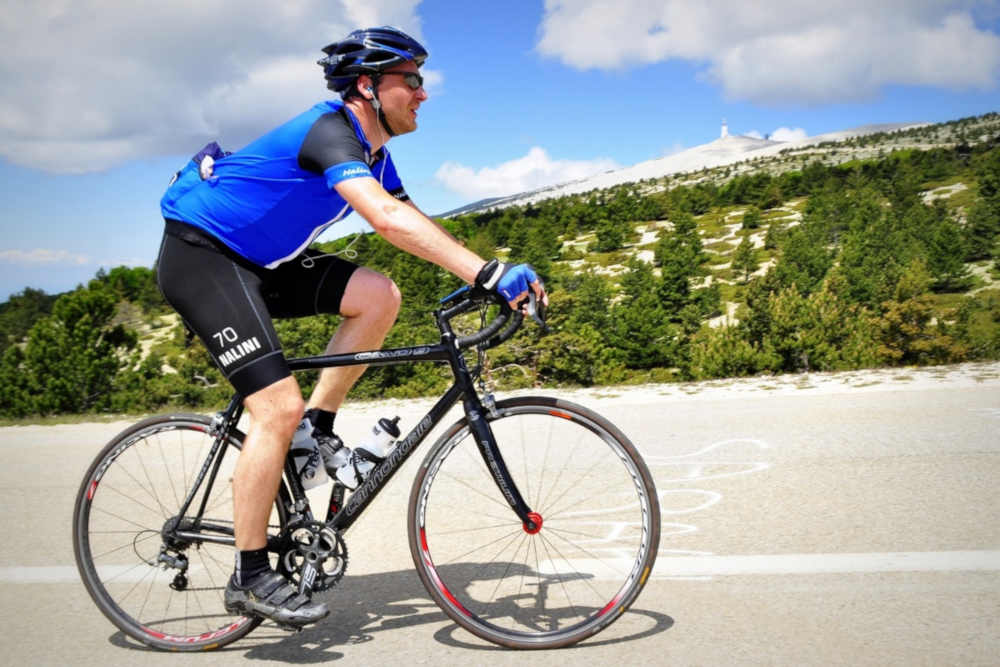

In [3]:
from PIL import Image
Image.open('/content/drive/My Drive/Image Captioning/cycle.jpg')

In [ ]:
# load and prepare the photograph
photo = extract_features('/content/drive/My Drive/Image Captioning/cycle.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)

#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
Image.open('/content/drive/My Drive/Image Captioning/voley.jpg')
result = ' '.join(resultwords)

print(result)

man in red shirt is riding bike on dirt path


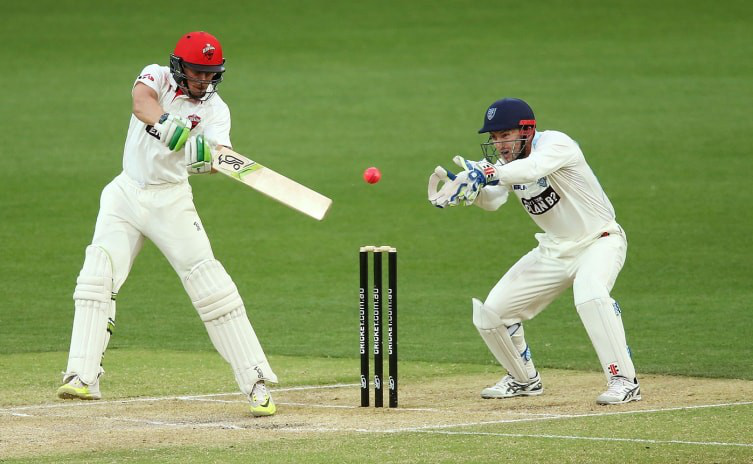

In [4]:
from PIL import Image
Image.open('/content/drive/My Drive/Image Captioning/cric.jpeg')

In [ ]:
# load and prepare the photograph
photo = extract_features('/content/drive/My Drive/Image Captioning/cric.jpeg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)

#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

two men playing soccer in the grass
